In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import platform

In [ ]:
if platform.system() == 'Linux':
    from google.colab import drive
    drive.mount('/content/drive')

### Download the CIFAR

In [3]:
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root='../../PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../../PYTORCH_NOTEBOOKS/PYTORCH_NOTEBOOKS/Data', train=False, download=True, transform=transform)

100.0%

Files already downloaded and verified


In [4]:
torch.manual_seed(101)

# Defining the batch size
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In [5]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
for images, labels in train_loader:
    break

In [8]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [    7     3     8     7     2     8     4     9     6     7]
Class:  horse cat ship horse bird ship deer truck frog horse


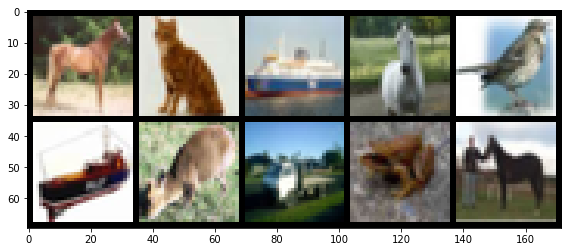

In [12]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Create the model

We make 6x6x16 in the first fully conected layer because we reduce in 2 per conv layer and divide by 2 per pooling layer and these is the output given

This is aproximated to 6 and then multiplied by the 16 filters of the last conv layer and the 6 output filters from the first one

In [14]:
print((((32-2)/2)-2)/2)
print(6*6*16)

6.5
576


In [17]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16) # here we do the resize for get the correct size of input in the fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [18]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

We can see that although this is a convolutional neural network that analyze color images it also have less parameters than the ANN for the MNIST that it had **105214** parameters and this only **81590** parameters

In [20]:
num_params = 0
for param in model.parameters():
    num_params += param.numel()
    print(param.numel())
print(f'The network it has {num_params} parameters')

450
6
864
16
69120
120
10080
84
840
10
The network it has 81590 parameters


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

# Trackers
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        b+= 1
        y_pred = model(X_train) # no flat
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum() # true / false pick the trues and sum them
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \ accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            b += 1

            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")